In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from scipy import stats
import os

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.family'] = 'DejaVu Sans'

colors = {
    'lora': '#1f77b4',  # blue
    'adapter': '#ff7f0e',  # orange
    'full-ft': '#2ca02c',  # green
    'bg_lora': '#d2e7f7',  # light blue
    'bg_adapter': '#fff2d9',  # light orange
    'bg_full-ft': '#d7f4d7'  # light green
}

In [2]:
import torch
print(torch.__version__)            # 应输出2.0.0+cu117
print(torch.cuda.is_available())    # 应输出True
print(torch.version.cuda)           # 应输出11.7
print(torch.cuda.get_device_name(0))# 显示GPU型号（如NVIDIA RTX 3060）[6,7](@ref)

2.0.0
True
11.7
NVIDIA GeForce RTX 3070 Ti Laptop GPU


### 1. 实验设计
seed: [42,43,44,45,46]

### 2. 数据处理 

In [3]:
def process_experiment_data(data):
    """处理实验数据，提取关键指标"""
    experiments = []
    
    for exp in data:
        # 提取配置信息
        config = exp['experiment_config']
        method = config['method']
        seed = config['seed']
        dataset = config['dataset']
        
        # 提取训练指标
        epochs = []
        for epoch_data in exp['training_metrics']:
            epoch_num = epoch_data['epoch']
            time_metrics = epoch_data['time_metrics']
            eval_metrics = epoch_data['evaluation']
            
            # 对于AG News数据集，只有最后一个epoch有pearson值
            pearson = eval_metrics.get('pearson', None)
            
            epoch_info = {
                'epoch': epoch_num,
                'data_transfer': time_metrics['data_transfer'],
                'forward': time_metrics['forward'],
                'backward': time_metrics['backward'],
                'optimizer_step': time_metrics['optimizer_step'],
                'epoch_duration': time_metrics['epoch_duration'],
                'eval_duration': eval_metrics['duration'],
                'pearson': pearson
            }
            
            epochs.append(epoch_info)
        
        # 计算各项指标的均值
        avg_metrics = {
            'avg_epoch_duration': np.mean([e['epoch_duration'] for e in epochs]),
            'avg_eval_duration': np.mean([e['eval_duration'] for e in epochs]),
            'total_training_time': sum([e['epoch_duration'] for e in epochs]),
            'max_pearson': max([e['pearson'] for e in epochs if e['pearson'] is not None], default=None),
            'final_pearson': epochs[-1]['pearson'] if epochs[-1]['pearson'] is not None else None
        }
        
        # 合并数据
        exp_info = {
            'method': method,
            'seed': seed,
            'dataset': dataset,
            'epochs': epochs,
            'metrics': avg_metrics
        }
        
        experiments.append(exp_info)
    
    return experiments

def create_epochs_df(experiments):
    rows = []
    for exp in experiments:
        method = exp['method']
        seed = exp['seed']
        dataset = exp['dataset']
        
        for epoch_data in exp['epochs']:
            row = {
                'method': method,
                'seed': seed,
                'dataset': dataset,
                'epoch': epoch_data['epoch'],
                'data_transfer': epoch_data['data_transfer'],
                'forward': epoch_data['forward'],
                'backward': epoch_data['backward'],
                'optimizer_step': epoch_data['optimizer_step'],
                'epoch_duration': epoch_data['epoch_duration'],
                'eval_duration': epoch_data['eval_duration'],
                'pearson': epoch_data['pearson']
            }
            rows.append(row)
    
    return pd.DataFrame(rows)

def create_experiments_df(experiments):
    rows = []
    for exp in experiments:
        row = {
            'method': exp['method'],
            'seed': exp['seed'],
            'dataset': exp['dataset'],
            'avg_epoch_duration': exp['metrics']['avg_epoch_duration'],
            'avg_eval_duration': exp['metrics']['avg_eval_duration'],
            'total_training_time': exp['metrics']['total_training_time'],
            'max_pearson': exp['metrics']['max_pearson'],
            'final_pearson': exp['metrics']['final_pearson']
        }
        rows.append(row)
    
    return pd.DataFrame(rows)

In [4]:
import json
with open('./data/stsb_lora_rank3.json', 'r') as f:
    stsb_lora_data = json.load(f)
with open('./data/stsb_adapter.json', 'r') as f:
    stsb_adapter_data = json.load(f)  
with open('./data/stsb_fullft.json', 'r') as f:
    stsb_fullft_data = json.load(f)  
with open('./data/ag_news_lora.json', 'r') as f:
    ag_news_lora_data = json.load(f)  
with open('./data/ag_news_adapter.json', 'r') as f:
    ag_news_adapter_data = json.load(f)

stsb_lora_experiments = process_experiment_data(stsb_lora_data)
stsb_adapter_experiments = process_experiment_data(stsb_adapter_data)
stsb_fullft_experiments = process_experiment_data(stsb_fullft_data)
ag_news_lora_experiments = process_experiment_data(ag_news_lora_data)
ag_news_adapter_experiments = process_experiment_data(ag_news_adapter_data)

all_experiments = stsb_lora_experiments + stsb_adapter_experiments + stsb_fullft_experiments + ag_news_lora_experiments + ag_news_adapter_experiments

epochs_df = create_epochs_df(all_experiments)
experiments_df = create_experiments_df(all_experiments)

stsb_epochs_df = epochs_df[epochs_df['dataset'] == 'stsb']
ag_news_epochs_df = epochs_df[epochs_df['dataset'] == 'ag_news']
stsb_experiments_df = experiments_df[experiments_df['dataset'] == 'stsb']
ag_news_experiments_df = experiments_df[experiments_df['dataset'] == 'ag_news']

### 3. 性能分析
#### 3.1 STS-B数据集上的学习曲线比较

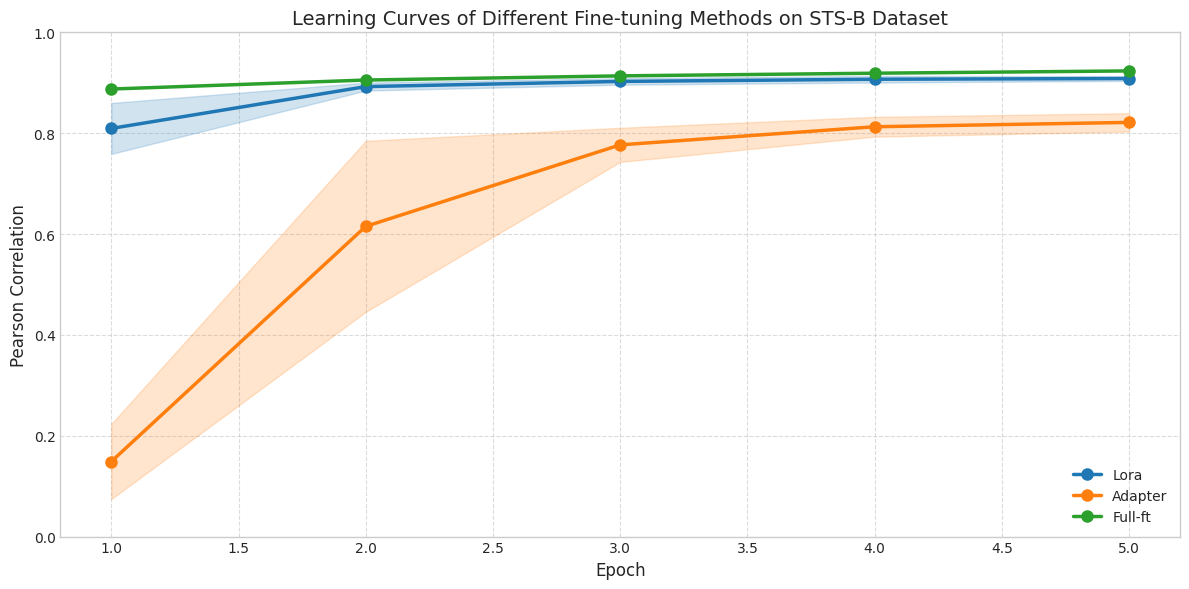

,Epoch 1 Avg Performance,Epoch 1 Std Dev,Epoch 1 CV (%),Final Performance Avg,Final Performance Std Dev,Final Performance CV (%)
method,,,,,,
adapter,0.148865,0.074448,50.010172,0.821389,0.018254,2.222363
full-ft,0.887543,NaN,NaN,0.923482,NaN,NaN
lora,0.809411,0.050502,6.239406,0.908402,0.004665,0.513589


In [5]:
plt.figure(figsize=(12, 6))

for method, color in [('lora', colors['lora']), ('adapter', colors['adapter']), ('full-ft', colors['full-ft'])]:
    method_data = stsb_epochs_df[stsb_epochs_df['method'] == method]
    
    grouped = method_data.groupby('epoch')
    mean_pearson = grouped['pearson'].mean()
    std_pearson = grouped['pearson'].std()
    
    plt.plot(grouped.groups.keys(), mean_pearson, label=f'{method.capitalize()}', 
             color=color, linewidth=2.5, marker='o', markersize=8)
    
    plt.fill_between(grouped.groups.keys(), 
                     mean_pearson - std_pearson, 
                     mean_pearson + std_pearson, 
                     alpha=0.2, color=color)

plt.xlabel('Epoch')
plt.ylabel('Pearson Correlation')
plt.title('Learning Curves of Different Fine-tuning Methods on STS-B Dataset')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.savefig('learning_curve_comparison.png', dpi=300)
plt.show()

first_epoch_stats = stsb_epochs_df[stsb_epochs_df['epoch'] == 1].groupby('method')['pearson'].agg(['mean', 'std'])
first_epoch_stats['cv'] = first_epoch_stats['std'] / first_epoch_stats['mean'] * 100
final_epoch_stats = stsb_epochs_df[stsb_epochs_df['epoch'] == 5].groupby('method')['pearson'].agg(['mean', 'std'])
final_epoch_stats['cv'] = final_epoch_stats['std'] / final_epoch_stats['mean'] * 100
performance_stats = pd.DataFrame({
    'Epoch 1 Avg Performance': first_epoch_stats['mean'],
    'Epoch 1 Std Dev': first_epoch_stats['std'],
    'Epoch 1 CV (%)': first_epoch_stats['cv'],
    'Final Performance Avg': final_epoch_stats['mean'],
    'Final Performance Std Dev': final_epoch_stats['std'],
    'Final Performance CV (%)': final_epoch_stats['cv']
})
performance_stats

#### 3.2 最终性能比较

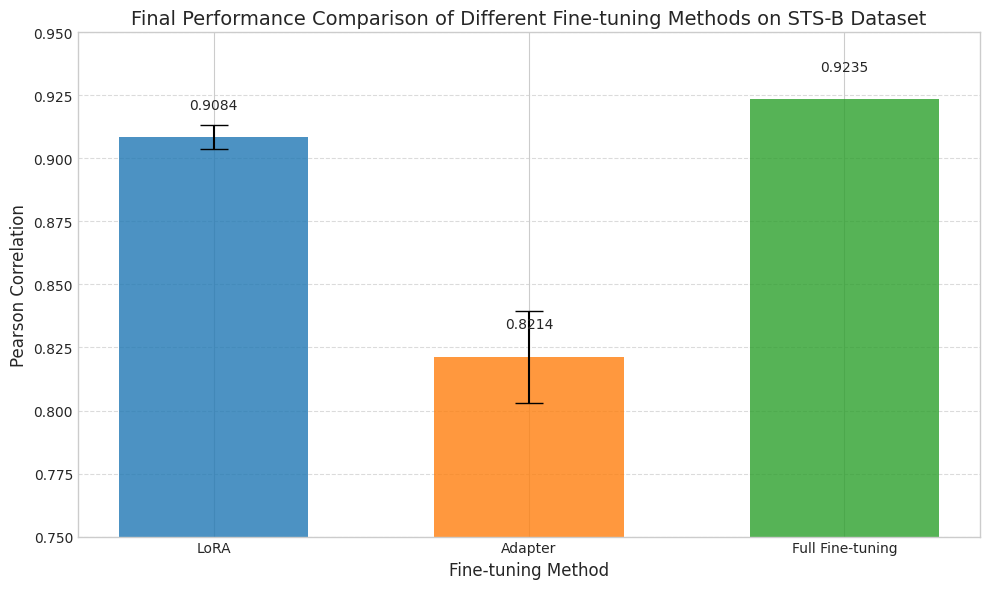

In [6]:
plt.figure(figsize=(10, 6))

lora_final = stsb_epochs_df[(stsb_epochs_df['method'] == 'lora') & (stsb_epochs_df['epoch'] == 5)]['pearson']
adapter_final = stsb_epochs_df[(stsb_epochs_df['method'] == 'adapter') & (stsb_epochs_df['epoch'] == 5)]['pearson']
fullft_final = stsb_epochs_df[(stsb_epochs_df['method'] == 'full-ft') & (stsb_epochs_df['epoch'] == 5)]['pearson']

methods = ['LoRA', 'Adapter', 'Full Fine-tuning']
means = [lora_final.mean(), adapter_final.mean(), fullft_final.mean()]
stds = [lora_final.std(), adapter_final.std(), fullft_final.std()]
colors_list = [colors['lora'], colors['adapter'], colors['full-ft']]

bars = plt.bar(methods, means, yerr=stds, capsize=10, color=colors_list, alpha=0.8, width=0.6)

for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2., mean + 0.01, f'{mean:.4f}', 
            ha='center', va='bottom', fontsize=10)

plt.xlabel('Fine-tuning Method')
plt.ylabel('Pearson Correlation')
plt.title('Final Performance Comparison of Different Fine-tuning Methods on STS-B Dataset')
plt.ylim(0.75, 0.95)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

plt.tight_layout()
plt.savefig('final_performance_comparison.png', dpi=300)
plt.show()

### 4. 效率分析
#### 4.1 参数量分析

(0.0, 110.0)

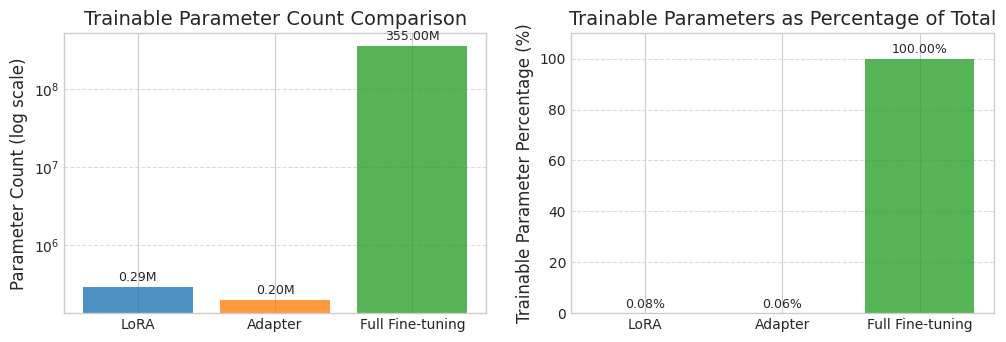

In [7]:
# Roberta-large model parameter count
roberta_large_params = 355e6  # 355M parameters

# Estimate trainable parameter count for different methods
lora_trainable_params = 4 * 1024 * 3 * 24  # 4 matrices(q,k,v,o) * hidden dim 1024 * rank 3 * 24 layers
adapter_trainable_params = 24 * (1024 * 3 + 3 * 1024 + 1024 + 1024)  # 24 transformer layers * (down+up+two LayerNorms)

methods = ['LoRA', 'Adapter', 'Full Fine-tuning']
total_params = [roberta_large_params, roberta_large_params, roberta_large_params]
trainable_params = [lora_trainable_params, adapter_trainable_params, roberta_large_params]
param_percents = [100 * p / roberta_large_params for p in trainable_params]

plt.figure(figsize=(12, 8))

# Trainable parameter count bar chart (log scale)
plt.subplot(2, 2, 1)
bars = plt.bar(methods, trainable_params, color=[colors['lora'], colors['adapter'], colors['full-ft']], alpha=0.8)
plt.yscale('log')
plt.ylabel('Parameter Count (log scale)')
plt.title('Trainable Parameter Count Comparison')
for bar, param in zip(bars, trainable_params):
    plt.text(bar.get_x() + bar.get_width()/2., param * 1.1, f'{param/1e6:.2f}M', 
             ha='center', va='bottom', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Trainable parameter percentage
plt.subplot(2, 2, 2)
bars = plt.bar(methods, param_percents, color=[colors['lora'], colors['adapter'], colors['full-ft']], alpha=0.8)
plt.ylabel('Trainable Parameter Percentage (%)')
plt.title('Trainable Parameters as Percentage of Total')
for bar, percent in zip(bars, param_percents):
    plt.text(bar.get_x() + bar.get_width()/2., percent + 1, f'{percent:.2f}%', 
             ha='center', va='bottom', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.ylim(0, 110)

#### 4.2 训练时间分析

,Avg Epoch Duration (s),Total Training Time (s),Data Transfer (s),Forward Pass (s),Backward Pass (s),Optimizer Step (s)
Method,,,,,,
LoRA,172.8816,864.408,39.2584,31.4524,99.0892,2.0376
Adapter,148.2724,741.362,47.9016,28.4844,68.1292,2.3720
Full Fine-tuning,331.1980,1655.990,17.1660,57.0320,181.9160,23.3020


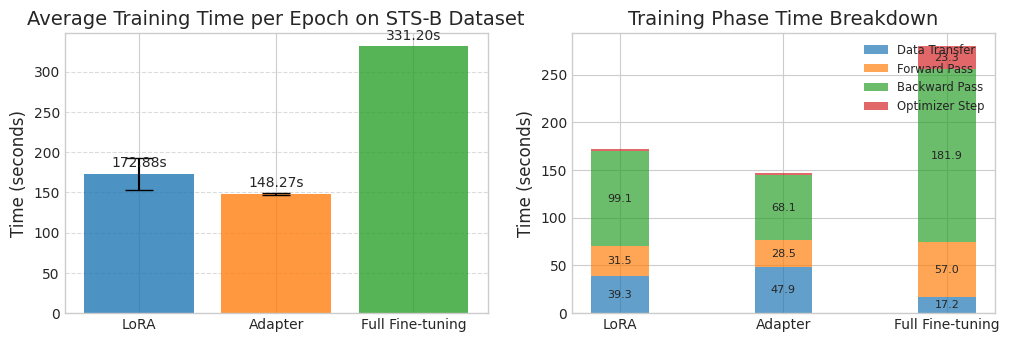

In [11]:
# 创建一个包含2x2网格的图形
plt.figure(figsize=(12, 8))

# 第一个子图：平均训练时间 (位置 1)
plt.subplot(2, 2, 1)
methods = ['LoRA', 'Adapter', 'Full Fine-tuning']

# 计算每种方法的时间统计
lora_time_stats = stsb_experiments_df[stsb_experiments_df['method'] == 'lora'][['avg_epoch_duration', 'total_training_time']].agg(['mean', 'std'])
adapter_time_stats = stsb_experiments_df[stsb_experiments_df['method'] == 'adapter'][['avg_epoch_duration', 'total_training_time']].agg(['mean', 'std'])
fullft_time_stats = stsb_experiments_df[stsb_experiments_df['method'] == 'full-ft'][['avg_epoch_duration', 'total_training_time']].agg(['mean', 'std'])

means = [lora_time_stats.loc['mean', 'avg_epoch_duration'], 
         adapter_time_stats.loc['mean', 'avg_epoch_duration'],
         fullft_time_stats.loc['mean', 'avg_epoch_duration']]
stds = [lora_time_stats.loc['std', 'avg_epoch_duration'], 
        adapter_time_stats.loc['std', 'avg_epoch_duration'],
        fullft_time_stats.loc['std', 'avg_epoch_duration']]

bars = plt.bar(methods, means, yerr=stds, capsize=10, 
              color=[colors['lora'], colors['adapter'], colors['full-ft']], alpha=0.8)

for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2., mean + 5, f'{mean:.2f}s', 
             ha='center', va='bottom', fontsize=10)

plt.ylabel('Time (seconds)')
plt.title('Average Training Time per Epoch on STS-B Dataset')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# 第二个子图：训练阶段时间分解 (位置 2)
plt.subplot(2, 2, 2)

# Extract average time for each phase
lora_phases = stsb_epochs_df[stsb_epochs_df['method'] == 'lora'].groupby('epoch')[['data_transfer', 'forward', 'backward', 'optimizer_step']].mean().mean()
adapter_phases = stsb_epochs_df[stsb_epochs_df['method'] == 'adapter'].groupby('epoch')[['data_transfer', 'forward', 'backward', 'optimizer_step']].mean().mean()
fullft_phases = stsb_epochs_df[stsb_epochs_df['method'] == 'full-ft'].groupby('epoch')[['data_transfer', 'forward', 'backward', 'optimizer_step']].mean().mean()

# Create stacked bar chart data
phases = ['Data Transfer', 'Forward Pass', 'Backward Pass', 'Optimizer Step']
lora_times = [lora_phases['data_transfer'], lora_phases['forward'], lora_phases['backward'], lora_phases['optimizer_step']]
adapter_times = [adapter_phases['data_transfer'], adapter_phases['forward'], adapter_phases['backward'], adapter_phases['optimizer_step']]
fullft_times = [fullft_phases['data_transfer'], fullft_phases['forward'], fullft_phases['backward'], fullft_phases['optimizer_step']]

# Create stacked bar chart
x = np.arange(3)
width = 0.35

bottom = np.zeros(3)
colors_phases = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, phase in enumerate(phases):
    values = [lora_times[i], adapter_times[i], fullft_times[i]]
    p = plt.bar(x, values, width, label=phase, bottom=bottom, color=colors_phases[i], alpha=0.7)
    bottom += values
    
    # Add labels (only for longer times)
    for j, v in enumerate(values):
        if v > 5:  # Only add labels for larger values
            plt.text(x[j], bottom[j] - v/2, f'{v:.1f}', ha='center', va='center', fontsize=8)

plt.ylabel('Time (seconds)')
plt.title('Training Phase Time Breakdown')
plt.xticks(x, ['LoRA', 'Adapter', 'Full Fine-tuning'])
plt.legend(loc='upper right', fontsize='small')

# 显示训练时间统计信息表
time_stats_df = pd.DataFrame({
    'Method': ['LoRA', 'Adapter', 'Full Fine-tuning'],
    'Avg Epoch Duration (s)': [lora_time_stats.loc['mean', 'avg_epoch_duration'], 
                              adapter_time_stats.loc['mean', 'avg_epoch_duration'],
                              fullft_time_stats.loc['mean', 'avg_epoch_duration']],
    'Total Training Time (s)': [lora_time_stats.loc['mean', 'total_training_time'], 
                               adapter_time_stats.loc['mean', 'total_training_time'],
                               fullft_time_stats.loc['mean', 'total_training_time']],
    'Data Transfer (s)': [lora_phases['data_transfer'], 
                          adapter_phases['data_transfer'],
                          fullft_phases['data_transfer']],
    'Forward Pass (s)': [lora_phases['forward'], 
                         adapter_phases['forward'],
                         fullft_phases['forward']],
    'Backward Pass (s)': [lora_phases['backward'], 
                          adapter_phases['backward'],
                          fullft_phases['backward']],
    'Optimizer Step (s)': [lora_phases['optimizer_step'], 
                           adapter_phases['optimizer_step'],
                           fullft_phases['optimizer_step']]
})

time_stats_df.set_index('Method', inplace=True)
time_stats_df

### 5. 稳定性分析

In [ ]:
# 创建一个2x2网格的大图形
plt.figure(figsize=(15, 12))

# 1. 训练时间稳定性比较
plt.subplot(2, 2, 1)
sns.boxplot(x='method', y=0, data=time_cv, hue='method', 
            palette={'lora': colors['lora'], 'adapter': colors['adapter']}, legend=False)
plt.ylim(0,2)
plt.xlabel('Fine-tuning Method')
plt.ylabel('Training Time CV (%)')
plt.title('Training Time Stability Comparison')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

In [ ]:
# 创建一个2x2网格的大图形
plt.figure(figsize=(15, 12))

# 2. 数据集规模影响分析
plt.subplot(2, 2, 1)
x = np.arange(2)  # 两个数据集
width = 0.35  # 条形宽度
methods = ['lora', 'adapter']
datasets = dataset_time_pivot.index

rects1 = plt.bar(x - width/2, dataset_time_pivot['lora'], width, label='LoRA', color=colors['lora'], alpha=0.8)
rects2 = plt.bar(x + width/2, dataset_time_pivot['adapter'], width, label='Adapter', color=colors['adapter'], alpha=0.8)

# 添加数据标签
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.1f}s',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.ylabel('Average Training Time per Epoch (s)')
plt.title('Training Time Comparison for Different Dataset Scales')
plt.xticks(x, ['STS-B\n(Small)', 'AG News\n(Large)'])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# 添加数据集大小信息
plt.annotate("STS-B: ~5.7k samples, AG News: ~120k samples", 
             xy=(0.5, -0.15), xycoords='axes fraction', 
             ha="center", fontsize=9, style='italic')

# 3. 比率图表
plt.subplot(2, 2, 2)
bars = plt.bar(datasets, dataset_time_pivot['lora/adapter'], color='#7f7f7f', alpha=0.8)

for bar, ratio in zip(bars, dataset_time_pivot['lora/adapter']):
    plt.text(bar.get_x() + bar.get_width()/2., ratio + 0.05, f'{ratio:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7)
plt.text(0.5, 1.03, "Equal line", color='r', ha='center')

plt.xlabel('Dataset')
plt.ylabel('Training Time Ratio (LoRA/Adapter)')
plt.title('LoRA/Adapter Training Time Ratio')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

plt.tight_layout()
plt.savefig('efficiency_comparison.png', dpi=300)
plt.show()